In [180]:
import os 
if os.environ.get("preamble_run", None) is not None: 
    print("Not re-runnning preamble")
else: 
    %run -i ../preamble.py

Not re-runnning preamble


In [181]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from src.td3.test_model import find_latest_time

In [182]:
def prettify_run_name(run):
    parts = run.split("_")
    prettified = []
    for i in range(0, len(parts), 2):
        if i + 1 < len(parts):
            param = parts[i]
            value = parts[i + 1].replace("x", ".")
            if param == "no": 
                prettified.append(f"no {value}")
            else:
                prettified.append(f"{param}={value}")

    return " | ".join(prettified)

def clean_run_name(run):
    base_name =  run.split("__")[0]
    return prettify_run_name(base_name)

def clean_and_unify_run(run, logs): 
    cleaned_run_name = clean_run_name(run)
    
    re_run_idx = 1
    run = cleaned_run_name
    while run in logs:
        run = f"{cleaned_run_name} [{re_run_idx}]"
        re_run_idx += 1
    return run


In [183]:
data_dir = "./data/td3/HockeyOne-v0"

data = dict()
log_names = set()
model_paths = dict()

for experiment in os.listdir(data_dir):
    for run in os.listdir(os.path.join(data_dir, experiment)):

        run_name = clean_and_unify_run(run, data)
        data[run_name] = dict()

        model_dir = f"models/td3/HockeyOne-v0/{experiment}/{run}"
        checkpoint = find_latest_time("*.model", model_dir)

        model_paths[run_name] = f"td3:{model_dir}/{checkpoint}.model"
        for file in os.listdir(os.path.join(data_dir, experiment, run)):
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(data_dir, experiment, run, file))
                log_name = file[:-4].replace("-", "/")
                data[run_name][log_name] = df
                log_names.add(log_name)

In [184]:
all_runs = sorted(data.keys())

In [185]:
runs = [r for r in all_runs if "pn=0.2" in r]

In [186]:
print("Runs found:")
for run in runs: 
    print(f"  {run}")

Runs found:
  pn=0.2 | pr=0.5-0.4 | pr=intr-factor-0
  pn=0.2 | pr=0.5-0.4 | pr=intr-factor-0.5
  pn=0.2 | pr=0.5-0.4 | pr=intr-factor-1
  pn=0.2 | pr=0.5-0.4 | pr=intr-factor-1 [1]


In [187]:
cmap = plt.get_cmap("tab10")
run_colors = {run: cmap(i) for i, run in enumerate(runs)}

In [188]:
def plot_log(runs, log_name, ax, smoothing_window=100, less_smooth_window=10, alpha=0.2):
    for run in runs:
        if log_name in data[run]:
            df = data[run][log_name]
            less_smoothed_value = df["value"].rolling(window=less_smooth_window, center=True).mean()
            smoothed_value = df["value"].rolling(window=smoothing_window, center=True).mean()
            ax.plot(df["step"], less_smoothed_value, label=run, color=run_colors[run], alpha=alpha)
            ax.plot(df["step"], smoothed_value, label=run, color=run_colors[run])

In [189]:
opponent_eval = [l for l in log_names if "eval/" in l]
opponents = set([l.split("/")[1] for l in opponent_eval])

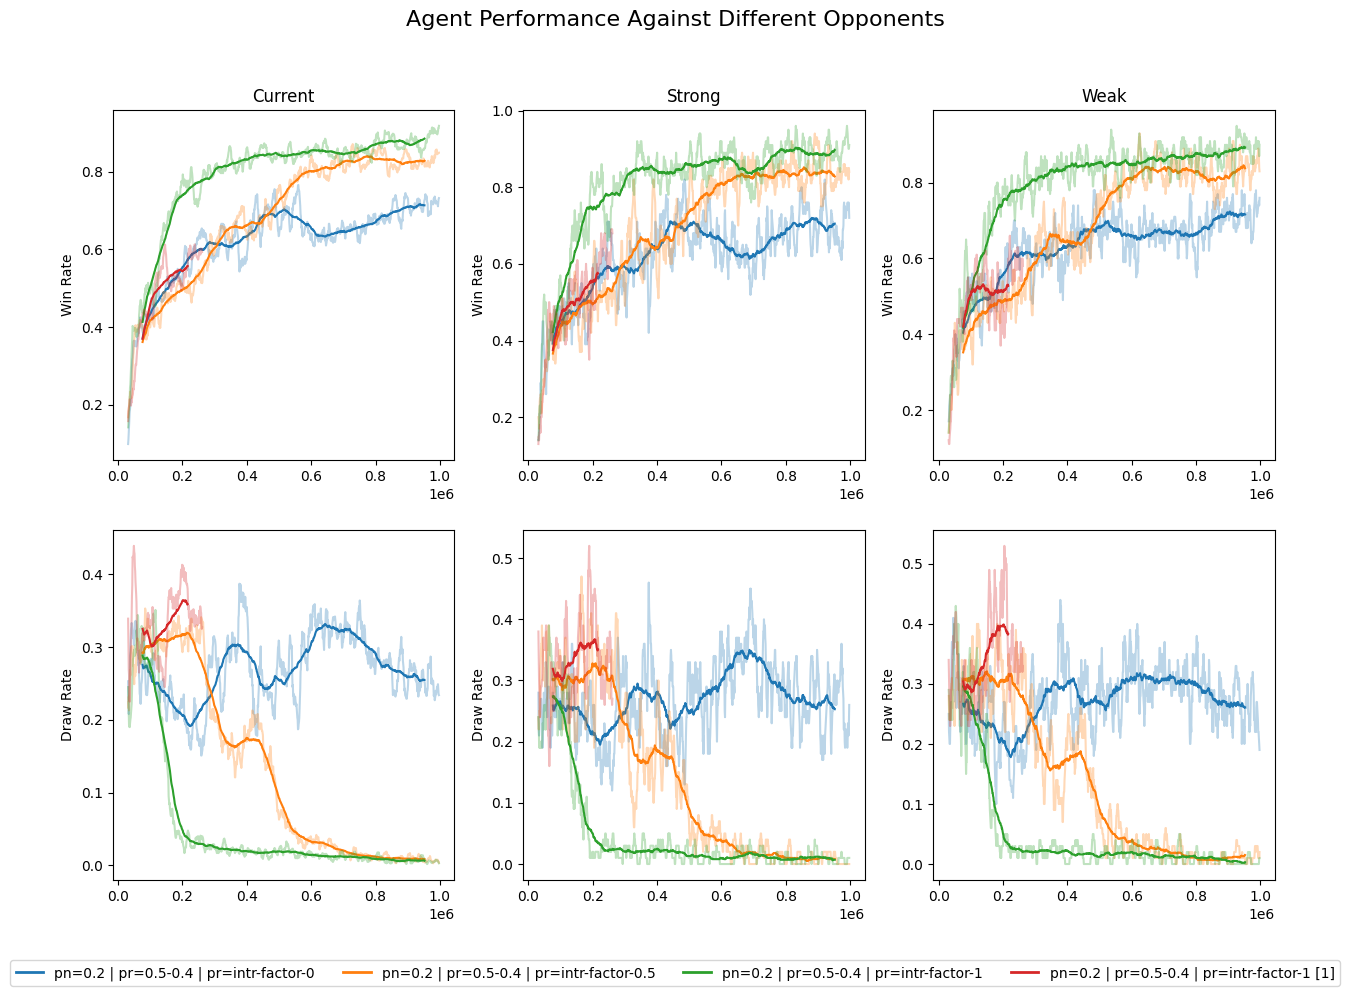

In [190]:
opponent_metrics = ["win_rate", "draw_rate"]
# opponent_metrics = ["win_rate", "lose_rate", "draw_rate"]

fig, axs = plt.subplots(len(opponent_metrics), len(opponents), figsize=(len(opponents)*5, len(opponent_metrics)*5))
fig.suptitle("Agent performance against different opponents".title(), fontsize=16)

for opponent_idx, opponent in enumerate(sorted(opponents)):
    if len(opponent_metrics) == 1:
        axs[opponent_idx].set_title(opponent.title())
    else:
        axs[0, opponent_idx].set_title(opponent.title())

    metric_axs = [axs[opponent_idx]] if len(opponent_metrics) == 1 else axs[:, opponent_idx]
    for metric, ax in zip(opponent_metrics, metric_axs):
        ax.set_ylabel(metric.replace("_", " ").title())
        plot_log(runs, f"eval/{opponent}/{metric}", ax, smoothing_window=100, less_smooth_window=10, alpha=0.3)
        
handles = [plt.Line2D([0], [0], color=run_colors[run], lw=2) for run in runs]

fig.legend(handles, runs, loc="lower center", ncol=len(runs))
# fig.legend(runs, loc="lower center", ncol=len(data), )

In [191]:
self_play_logs = [
    "self_play/player_elo",
    "self_play/opponent_elo",
    "self_play/n_opponents",
    "self_play/opponent_player_num_max",
    "self_play/opponent_player_num_median",
    "self_play/opponent_player_num_min",
]

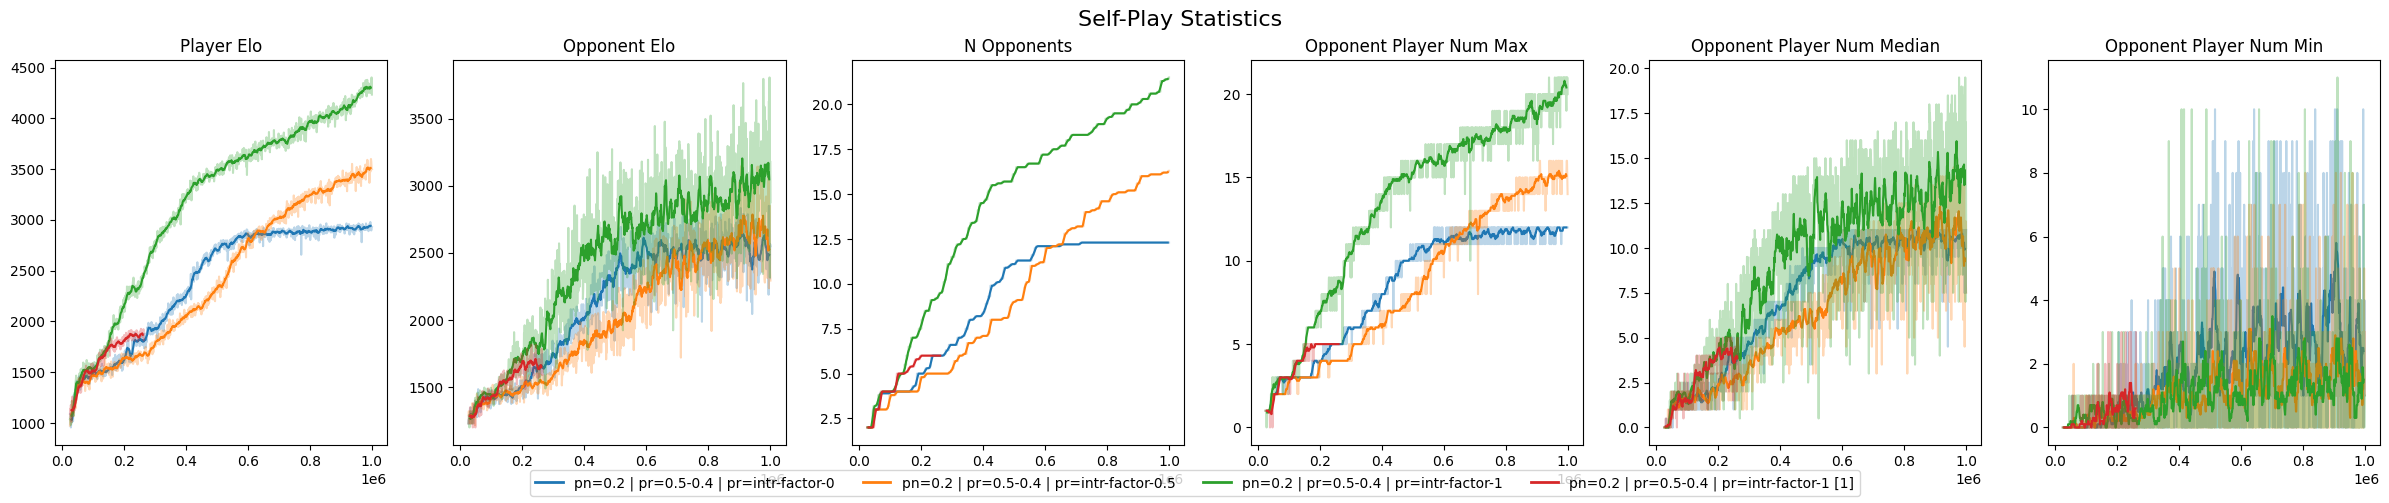

In [192]:
fig, axs = plt.subplots(1, len(self_play_logs), figsize=(len(self_play_logs)*5, 5))
fig.suptitle("Self-play statistics".title(), fontsize=16)

for idx, self_play_log in enumerate(self_play_logs):
    axs[idx].set_title(self_play_log.split("/")[1].replace("_", " ").title())

    # ax.set_ylabel(metric.replace("_", " ").title())
    plot_log(runs, self_play_log, axs[idx], smoothing_window=10, less_smooth_window=1, alpha=0.3)
        
handles = [plt.Line2D([0], [0], color=run_colors[run], lw=2) for run in runs]

fig.legend(handles, runs, loc="lower center", ncol=len(runs))
# fig.legend(runs, loc="lower center", ncol=len(data), )

In [193]:
from src.td3.algorithm.evaluation import run_evaluation, run_evaluation_multiple_runs
from hockey.hockey_env import Mode

player_paths = [model_paths[run] for run in runs]
player_paths = player_paths + ["weak_opponent", "strong_opponent"]
eval_run_names = runs + ["weak opponent", "strong opponent"]

n_eval_episodes = 10

results = run_evaluation_multiple_runs(player_paths, n_episodes=n_eval_episodes, render=False, seed=42, hockey_mode=Mode.NORMAL)

Loaded model from models/td3/HockeyOne-v0/prioritized_replay/pn_0x2_pr_0x5-0x4_pr_intr-factor-0__42__1771796853/1000000.model
Loaded model from models/td3/HockeyOne-v0/prioritized_replay/pn_0x2_pr_0x5-0x4_pr_intr-factor-0x5__42__1771796853/1000000.model
Loaded model from models/td3/HockeyOne-v0/prioritized_replay/pn_0x2_pr_0x5-0x4_pr_intr-factor-1__42__1771796853/1000000.model
Loaded model from models/td3/HockeyOne-v0/prioritized_replay/pn_0x2_pr_0x5-0x4_pr_intr-factor-1__42__1771845808/280000.model


Evaluating runs: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


In [194]:
scores = {}
all_player_metrics = ["win_rate", "draw_rate", "lose_rate"]

# all_player_metrics = ["win_rate"]
for i, metric in enumerate(all_player_metrics): 
    metric_results = []
    for player in player_paths: 
        player_results = results[player]
        def win_rate_for_opponent(opponent):
            if opponent not in player_results:
                return np.nan
            else: 
                return results[player][opponent][metric]
        metric_results.append([win_rate_for_opponent(opponent) for opponent in player_paths])
    scores[metric] = metric_results

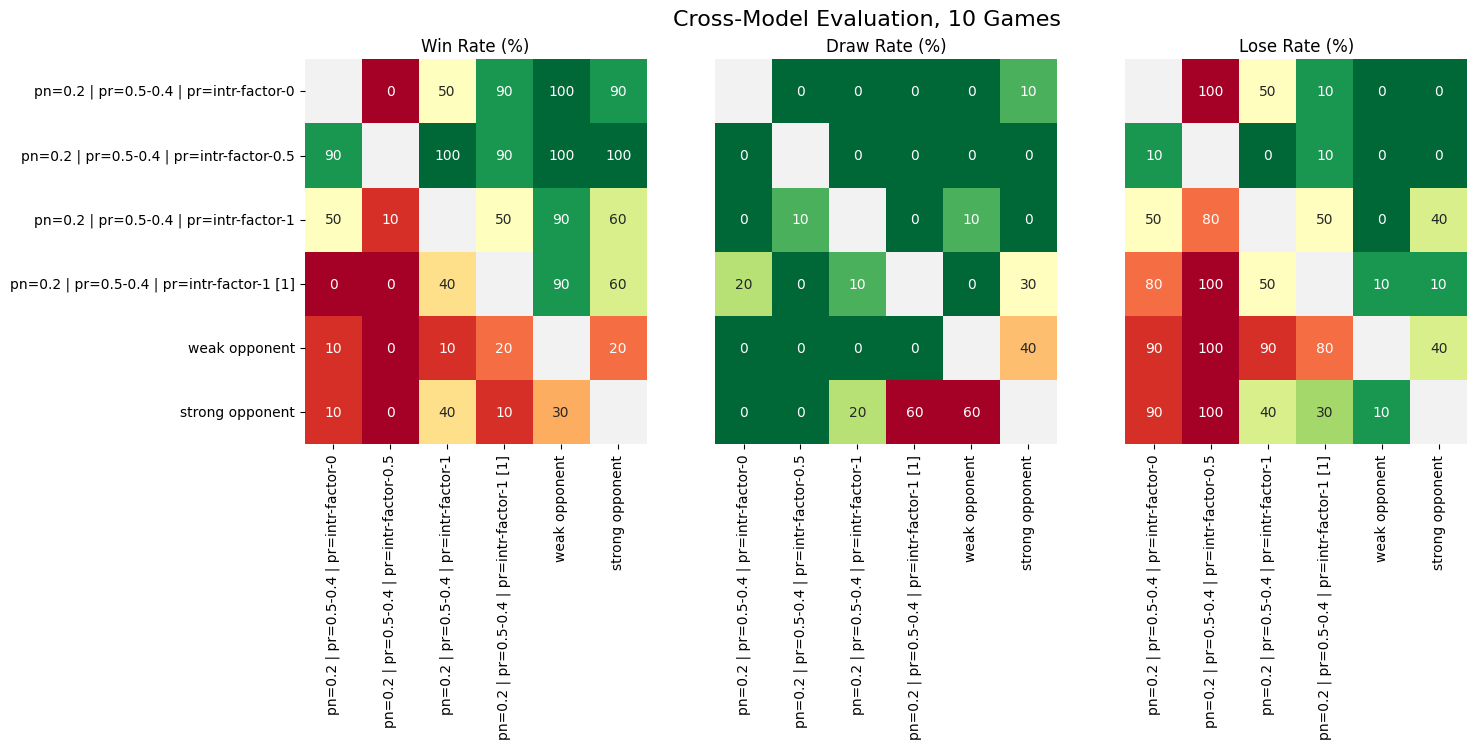

In [195]:
import numpy as np
from matplotlib import colormaps

# Convert win_rates to numpy array for better heatmap handling
fig, axs = plt.subplots(1, len(all_player_metrics), figsize=(len(all_player_metrics)*5, 5))

for i, metric in enumerate(all_player_metrics): 
    ax = axs if len(all_player_metrics) == 1 else axs[i]
    win_rates_array = np.array(scores[metric])
    win_rates_array = (win_rates_array*100)
    win_rates_array[np.diag_indices_from(win_rates_array)] = np.nan # hide out diagonal because playing against itself is not meaningful
    
    cmap = "RdYlGn" if metric == "win_rate" else "RdYlGn_r"
    cmap = colormaps[cmap].copy() 
    cmap.set_bad(color=(0.95, 0.95, 0.95)) 

    sns.heatmap(win_rates_array, cbar = False, annot=True, fmt=".0f", cmap=cmap, ax=ax, xticklabels=eval_run_names, yticklabels=[] if i > 0 else eval_run_names)
    ax.set_title(metric.replace("_", " ").title() + " (%)")

fig.suptitle(f"Cross-model evaluation, {n_eval_episodes} games".title(), fontsize=16)
None